In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import List, Tuple, Dict

import json
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.stats.diagnostic import acorr_ljungbox


# De M0 a M4

In [ ]:
def load_series(path: Path) -> pd.DataFrame:
    """
    Carrega a série num pandas.DataFrame

    Parameters
    ----------
    path : Path
        Caminho do arquivo

    Returns
    -------
    pd.DataFrame
        DataFrame com os dados do arquivo original.
    """
    df = pd.read_csv(path)
    df["week_dt"] = pd.to_datetime(df["week"])
    df = df.sort_values("week_dt").reset_index(drop=True)
    df["volume"] = df["volume"].astype(float)
    df["log_volume"] = np.log(df["volume"])
    df["dlog_volume"] = df["log_volume"].diff()
    return df.dropna().reset_index(drop=True)


def choose_period_stl(ts: pd.Series, candidates: List[int]) -> Tuple[int, pd.DataFrame]:
    """
    Função que escolhe a tendência e a sazonalidade com STL (Seasonal–Trend decomposition using Loess)

    Parameters
    ----------
    ts : pd.Series
        Série temporal
    candidates : List[int]
        Lista de candidato a período de sazonalidade

    Returns
    -------
    Tuple[int, pd.DataFrame]
        Tupla com o melhor período de sazonalidade juntamente com o DataFrame com os valores de 
        força de tendência e sazonalidade para cada período.
    """
    rows = []
    for m in candidates:
        res = STL(ts, period=m, robust=True).fit()
        
        # Força de tendência 
        Ft = max(0.0, 1.0 - np.var(res.resid) / np.var(res.trend + res.resid))
        
        # Força de sazonalidade
        Fs = max(0.0, 1.0 - np.var(res.resid) / np.var(res.seasonal + res.resid))
        rows.append({"period": m, "Ft": float(Ft), "Fs": float(Fs)})
        
    tab = pd.DataFrame(rows).sort_values("Fs", ascending=False).reset_index(drop=True)
    best = int(tab.loc[0, "period"])
    return best, tab


def add_stl_components(df: pd.DataFrame, period: int) -> pd.DataFrame:
    """
    Adds STL decomposition components (trend, seasonal, and trend difference) to a DataFrame.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame
    period : int
        Seasonal period

    Returns
    -------
    pd.DataFrame
        DataFrame with
        - 'trend_stl': Trend component from STL decomposition.
        - 'season_stl': Seasonal component from STL decomposition.
        - 'dtrend_stl': First difference of the trend component.
        - 't': Time index as a float array.
    """
    res = STL(df["volume"], period=period, robust=True).fit()
    out = df.copy()
    out["trend_stl"] = pd.Series(res.trend, index=out.index)
    out["season_stl"] = pd.Series(res.seasonal, index=out.index)
    out["dtrend_stl"] = out["trend_stl"].diff()
    out["t"] = np.arange(len(out), dtype=float)
    return out.dropna().reset_index(drop=True)


def design(y: pd.Series, Xcols: List[str], df: pd.DataFrame):
    """
    Prepares the response and design matrix for multiple linear regression.

    Parameters
    ----------
    y : pd.Series
        The name of the response variable (target column) as a string.
    Xcols : List[str]
        List of column names to be used as predictors (features).
    df : pd.DataFrame
        The DataFrame containing the data.

    Returns
    -------
    yv : np.ndarray
        The response variable as a NumPy array of floats.
    Xv : np.ndarray
        The design matrix (predictors with intercept) as a NumPy array of floats.
    names : List[str]
        List of column names in the design matrix, including the intercept ('const').

    Notes
    -----
    If `Xcols` is empty, the design matrix will only include the intercept term.
    """
    yv = df[y].to_numpy(dtype=float)
    Xv = sm.add_constant(df[Xcols].to_numpy(dtype=float), has_constant="add") if Xcols else sm.add_constant(np.zeros((len(df),0)))
    names = ["const"] + Xcols
    return yv, Xv, names


def fit_ols(y: np.ndarray, X: np.ndarray):
    """
    Fits an Ordinary Least Squares (OLS) regression model.

    Parameters
    ----------
    y : np.ndarray
        The dependent variable (target values), as a 1-dimensional NumPy array.
    X : np.ndarray
        The independent variables (predictors), as a 2-dimensional NumPy array.

    Returns
    -------
    res : RegressionResults
        The fitted OLS regression results object from statsmodels.

    Notes
    -----
    Rows with missing values in `y` or `X` are dropped before fitting the model.
    """
    model = sm.OLS(y, X, missing="drop")
    res = model.fit()
    return res


def loocv_mse(y: np.ndarray, X: np.ndarray, res) -> float:
    """
    Compute the Leave-One-Out Cross-Validation Mean Squared Error (LOOCV MSE) for a linear regression model.

    Parameters
    ----------
    y : np.ndarray
        The observed target values, shape (n_samples,).
    X : np.ndarray
        The design matrix (features), shape (n_samples, n_features).
    res : object
        The fitted regression result object, expected to have a `fittedvalues` attribute.

    Returns
    -------
    float
        The LOOCV mean squared error.

    Notes
    -----
    This function uses the hat matrix diagonal to efficiently compute LOOCV MSE without refitting the model n times.
    """
    XtX = X.T @ X
    XtX_inv = np.linalg.inv(XtX)
    H_diag = np.einsum('ij,jk,ik->i', X, XtX_inv, X)
    resid = y - res.fittedvalues
    return float(np.mean((resid / (1.0 - H_diag))**2))


def metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    """
    Calculate regression error metrics between true and predicted values.

    Parameters
    ----------
    y_true : np.ndarray
        Array of true target values.
    y_pred : np.ndarray
        Array of predicted target values.

    Returns
    -------
    Dict[str, float]
        Dictionary containing:
            - 'RMSE': Root Mean Squared Error
            - 'MAE': Mean Absolute Error
    """
    mse = float(np.mean((y_true - y_pred) ** 2))
    rmse = float(np.sqrt(mse))
    mae = float(np.mean(np.abs(y_true - y_pred)))
    return {"RMSE": rmse, "MAE": mae}



In [3]:
# 1) Load + transform
df0 = load_series(Path("data.csv"))

# 2) Escolher período sazonal via STL 
period_candidates = [4, 5, 13, 26, 52, 53]
best_period, stl_table = choose_period_stl(df0["volume"], period_candidates)

# 3) Adicionar tendência e sazonalidade com STL + tendência temporal
df = add_stl_components(df0, best_period)

# 4) Split temporal 80/20
n = len(df)
n_test = max(1, int(np.floor(0.2*n)))
train = df.iloc[:-n_test].copy()
test  = df.iloc[-n_test:].copy()

# 5) Especificações de modelos (STL trend/season + tendência em t)
models = {
    "M0_intercept": [],
    "M1_time_trend": ["t"],
    "M2_stl": ["dtrend_stl", "season_stl"],
    "M3_time_plus_stl": ["t", "dtrend_stl", "season_stl"],
}

rows = []
coef_tables = {}
pred_test = test[["week_dt", "dlog_volume"]].copy()

ljung = {}

for name, cols in models.items():
    y_tr, X_tr, names = design("dlog_volume", cols, train)
    res = fit_ols(y_tr, X_tr)
    y_te, X_te, _ = design("dlog_volume", cols, test)
    yhat_tr = res.predict(X_tr)
    yhat_te = res.predict(X_te)
    mtr = metrics(y_tr, yhat_tr)
    mte = metrics(y_te, yhat_te)
    r2_adj = float(res.rsquared_adj)
    loocv = loocv_mse(y_tr, X_tr, res)
    aic = float(res.aic); bic = float(res.bic)
    rows.append([name, r2_adj, loocv, aic, bic, mtr["RMSE"], mtr["MAE"], mte["RMSE"], mte["MAE"]])
    coef_df = pd.DataFrame({"term": names, "coef": res.params, "pvalue": res.pvalues})
    coef_tables[name] = coef_df
    pred_test[f"yhat_{name}"] = yhat_te
    ljung[name] = acorr_ljungbox(res.resid, lags=[10], return_df=True)

print(ljung)


{'M0_intercept':       lb_stat  lb_pvalue
10  24.942913   0.005455, 'M1_time_trend':       lb_stat  lb_pvalue
10  24.984016   0.005376, 'M2_stl':       lb_stat  lb_pvalue
10  23.684692   0.008483, 'M3_time_plus_stl':       lb_stat  lb_pvalue
10  23.706061    0.00842}


In [4]:


# 6) Testes F de inclusão (significância conjunta)
res_M0 = fit_ols(*design("dlog_volume", models["M0_intercept"], train)[:2])
res_M1 = fit_ols(*design("dlog_volume", models["M1_time_trend"], train)[:2])
res_M2 = fit_ols(*design("dlog_volume", models["M2_stl"], train)[:2])
res_M3 = fit_ols(*design("dlog_volume", models["M3_time_plus_stl"], train)[:2])


f_tests = {
    "time_trend_vs_intercept": {
        "F": float(res_M1.compare_f_test(res_M0)[0]),
        "pvalue": float(res_M1.compare_f_test(res_M0)[1]),
        "df_diff": int(res_M1.compare_f_test(res_M0)[2]),
    },
    "stl_vs_intercept": {
        "F": float(res_M2.compare_f_test(res_M0)[0]),
        "pvalue": float(res_M2.compare_f_test(res_M0)[1]),
        "df_diff": int(res_M2.compare_f_test(res_M0)[2]),
    },
    "time_plus_stl_vs_stl": {
        "F": float(res_M3.compare_f_test(res_M2)[0]),
        "pvalue": float(res_M3.compare_f_test(res_M2)[1]),
        "df_diff": int(res_M3.compare_f_test(res_M2)[2]),
    },
}

In [23]:
print(ljung.values())

dict_values([      lb_stat  lb_pvalue
10  24.942913   0.005455,       lb_stat  lb_pvalue
10  24.984016   0.005376,       lb_stat  lb_pvalue
10  23.684692   0.008483,       lb_stat  lb_pvalue
10  23.706061    0.00842])


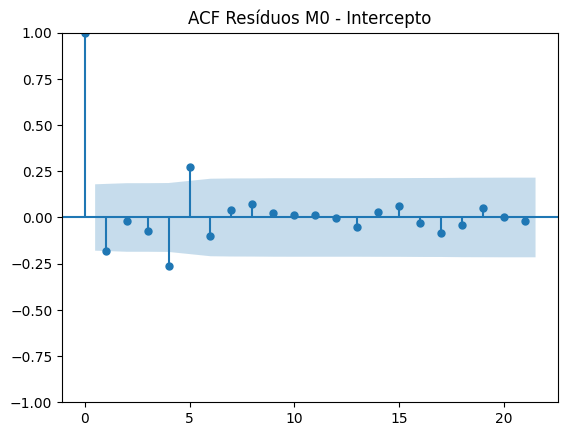

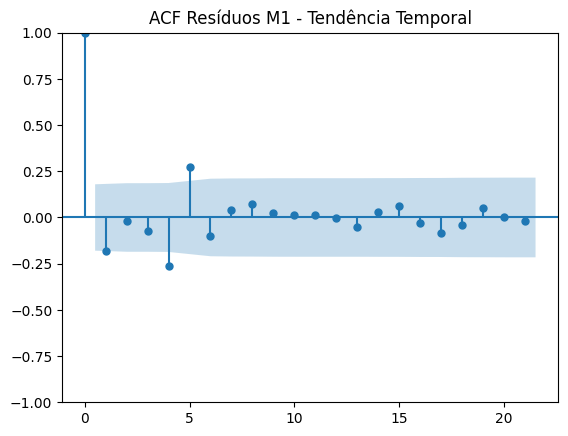

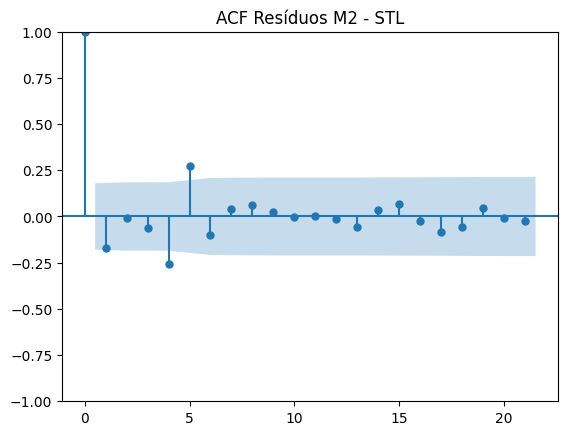

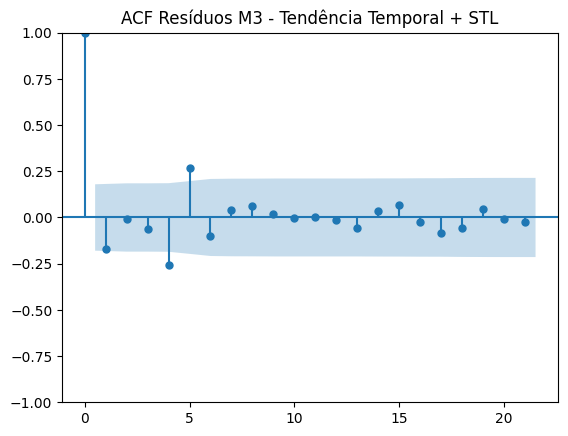

In [20]:
# plt.plot()

plot_acf(res_M0.resid, title="ACF Resíduos M0 - Intercepto")
plot_acf(res_M1.resid, title="ACF Resíduos M1 - Tendência Temporal")
plot_acf(res_M2.resid, title="ACF Resíduos M2 - STL")
plot_acf(res_M3.resid, title="ACF Resíduos M3 - Tendência Temporal + STL")
plot_acf(res_M3.resid, title="ACF Resíduos M3 - Tendência Temporal + STL")
plt.close()

In [25]:
# Criar variáveis auto-regressivas para capturar correlação serial nos resíduos
train['dlog_volume_lag4'] = train['dlog_volume'].shift(4)
train['dlog_volume_lag5'] = train['dlog_volume'].shift(5)
train = train.dropna().reset_index(drop=True)

In [26]:
res_M0_lag = fit_ols(*design("dlog_volume", models["M0_intercept"] + ["dlog_volume_lag4", "dlog_volume_lag5"], train)[:2])

,lb_stat,lb_pvalue
10,13.813245,0.181682


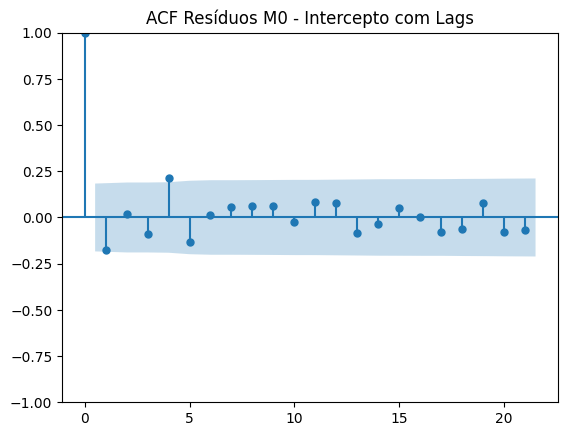

In [28]:
plot_acf(res_M0_lag.resid, title="ACF Resíduos M0 - Intercepto com Lags")
acorr_ljungbox(res_M0_lag.resid, lags=[10], return_df=True)

In [32]:
# Fazendo o mesmo para os outros modelos
res_M1_lag = fit_ols(*design("dlog_volume", models["M1_time_trend"] + ["dlog_volume_lag4", "dlog_volume_lag5"], train)[:2])
res_M2_lag = fit_ols(*design("dlog_volume", models["M2_stl"] + ["dlog_volume_lag4", "dlog_volume_lag5"], train)[:2])
res_M3_lag = fit_ols(*design("dlog_volume", models["M3_time_plus_stl"] + ["dlog_volume_lag4", "dlog_volume_lag5"], train)[:2])


print("M1")
display(acorr_ljungbox(res_M1_lag.resid, lags=[10], return_df=True))
print("M2")
display(acorr_ljungbox(res_M2_lag.resid, lags=[10], return_df=True))
print("M3")
display(acorr_ljungbox(res_M3_lag.resid, lags=[10], return_df=True))

M1


,lb_stat,lb_pvalue
10,13.809225,0.181873


M2


,lb_stat,lb_pvalue
10,14.114958,0.167812


M3


,lb_stat,lb_pvalue
10,14.145343,0.166465


In [34]:
new_tests = {
    "time_trend_vs_intercept": {
        "F": float(res_M1.compare_f_test(res_M0)[0]),
        "pvalue": float(res_M1.compare_f_test(res_M0)[1]),
        "df_diff": int(res_M1.compare_f_test(res_M0)[2]),
    },
    "stl_vs_intercept": {
        "F": float(res_M2.compare_f_test(res_M0)[0]),
        "pvalue": float(res_M2.compare_f_test(res_M0)[1]),
        "df_diff": int(res_M2.compare_f_test(res_M0)[2]),
    },
    "time_plus_stl_vs_stl": {
        "F": float(res_M3.compare_f_test(res_M2)[0]),
        "pvalue": float(res_M3.compare_f_test(res_M2)[1]),
        "df_diff": int(res_M3.compare_f_test(res_M2)[2]),
    },
}
new_tests

{'time_trend_vs_intercept': {'F': 0.021890244300732265,
  'pvalue': 0.8826341290859032,
  'df_diff': 1},
 'stl_vs_intercept': {'F': 1.171411839940591,
  'pvalue': 0.3135678914794219,
  'df_diff': 2},
 'time_plus_stl_vs_stl': {'F': 0.008937592513156765,
  'pvalue': 0.9248456561642311,
  'df_diff': 1}}

In [43]:
new_test_list = [{"Comparison": k, **v} for k, v in new_tests.items()]
pd.json_normalize(new_test_list)

,Comparison,F,pvalue,df_diff
0,time_trend_vs_intercept,0.021890,0.882634,1
1,stl_vs_intercept,1.171412,0.313568,2
2,time_plus_stl_vs_stl,0.008938,0.924846,1
